<a href="https://colab.research.google.com/github/IshanGProjects/Predicting_Rainfall_in_Australia_Using_Neural_Networks/blob/main/Predicting_Rainfall_in_Australia_Using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration and Preprocessing

## Inital Data Observation

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving weatherAUS.csv to weatherAUS.csv


In [ ]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Load the dataset using Pandas.
weatherDF = pd.read_csv('weatherAUS.csv')

# Display the first 5 rows of the DataFrame
print(weatherDF.head())

# Display information about the DataFrame
print(weatherDF.info())

# Display a statistical summary of numeric columns
print(weatherDF.describe())


         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

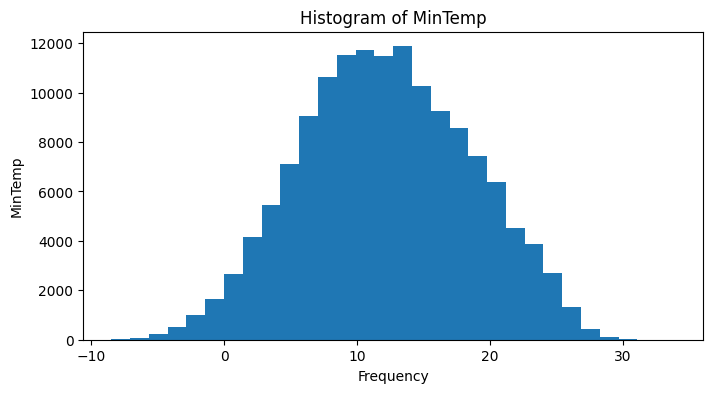

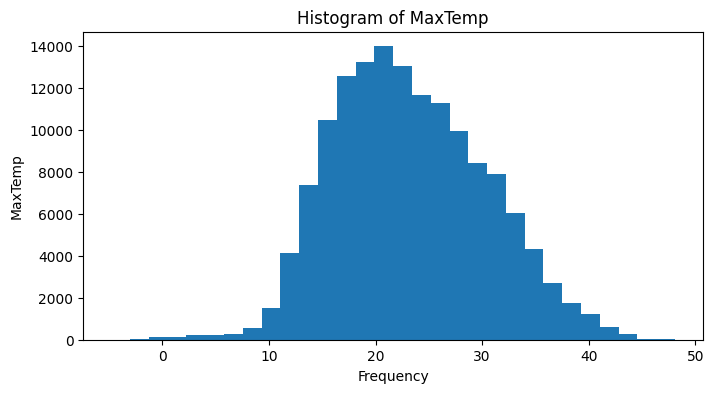

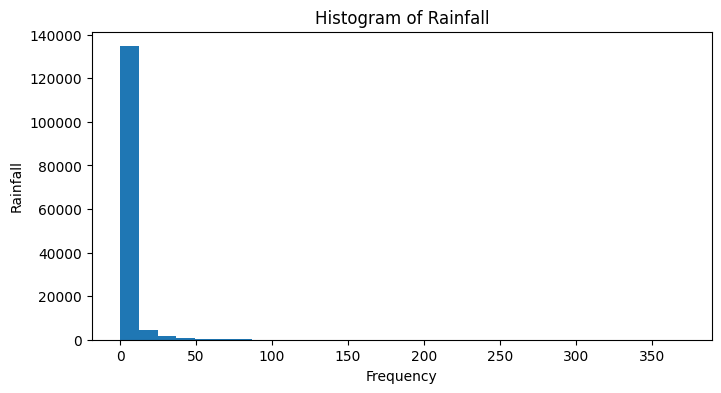

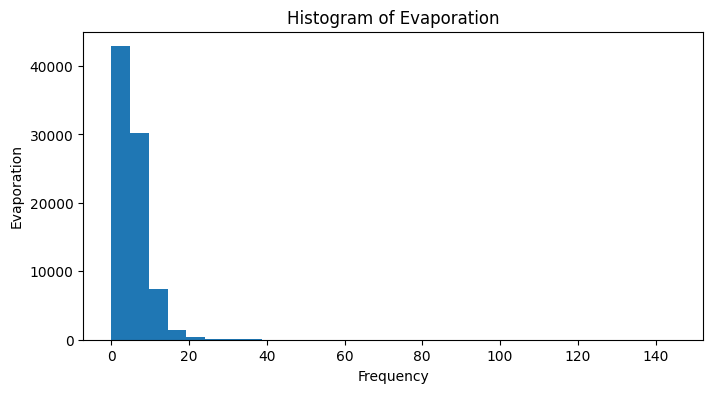

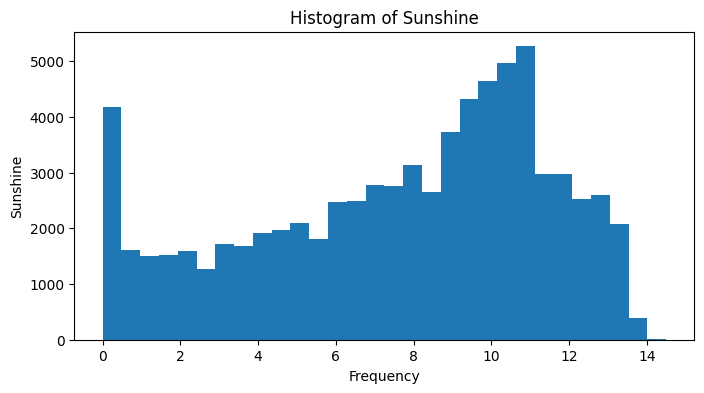

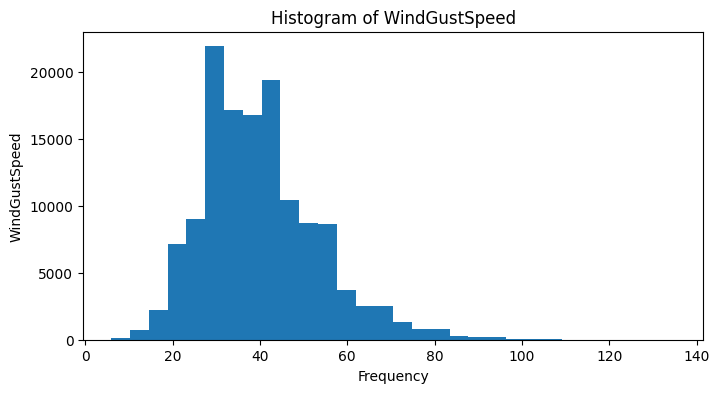

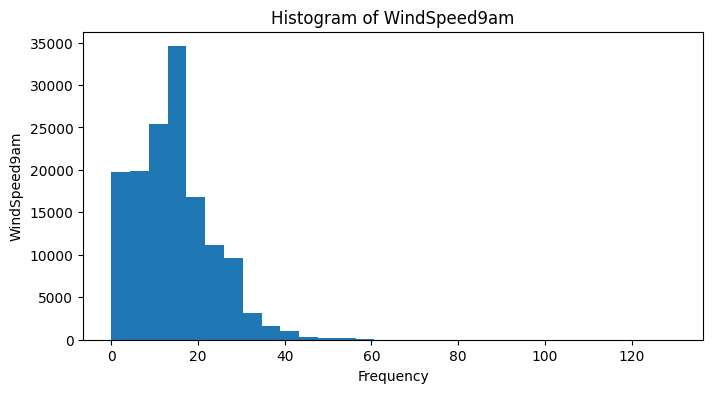

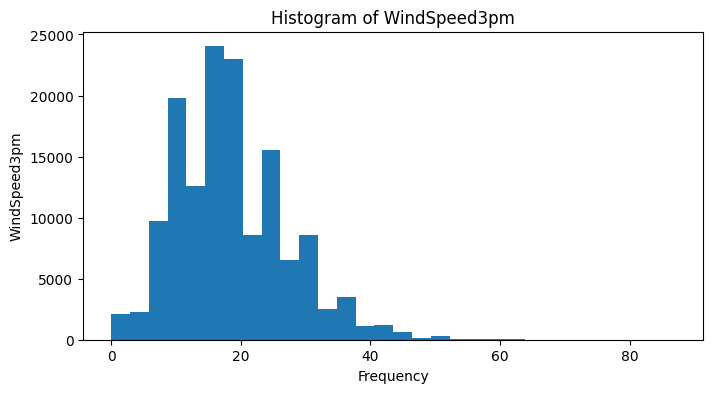

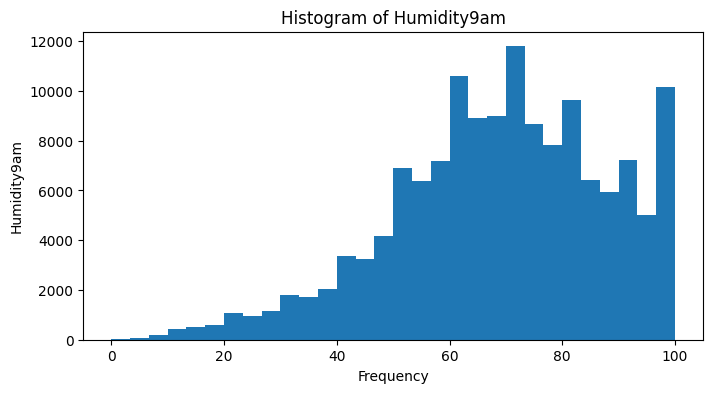

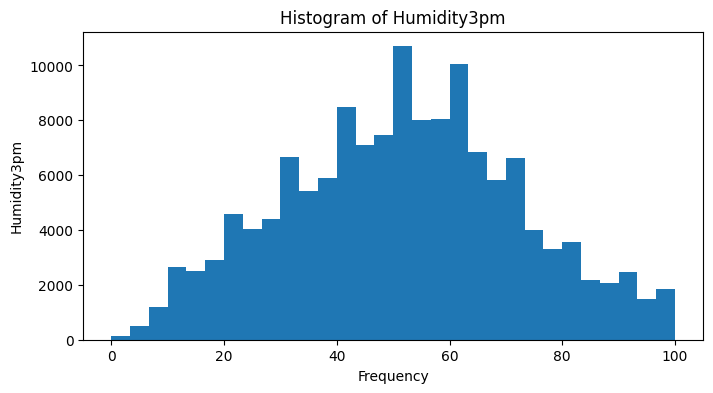

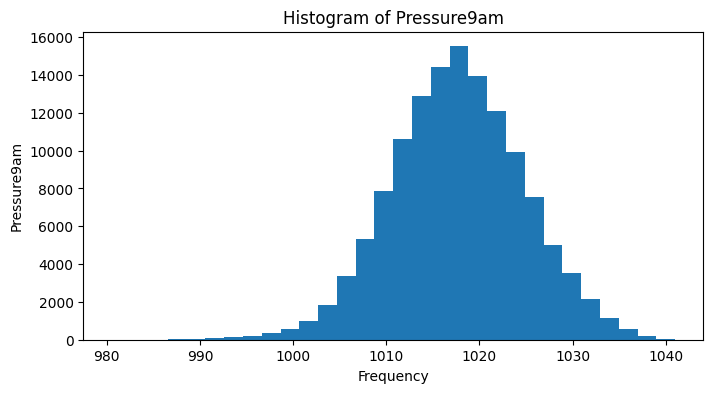

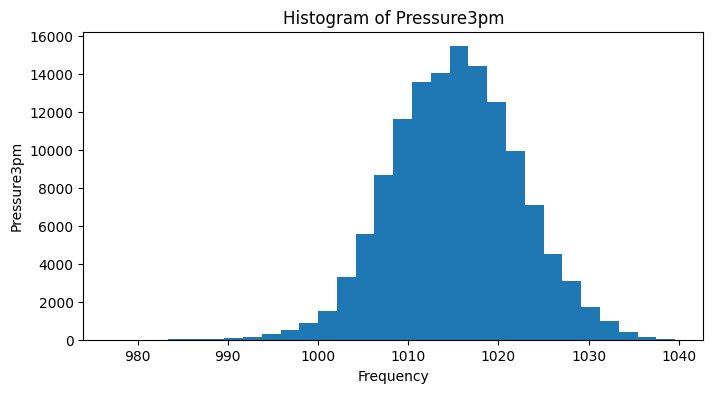

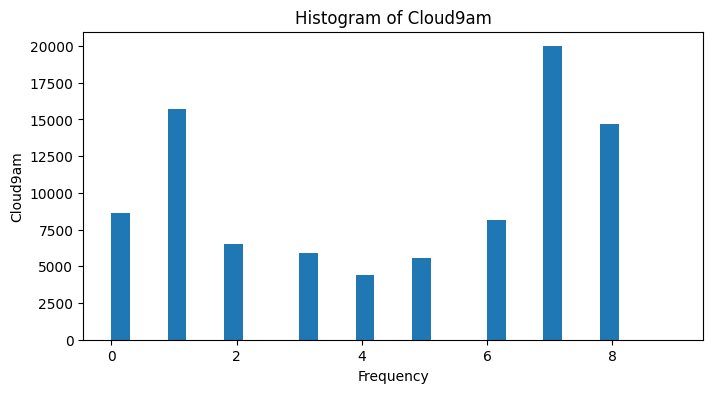

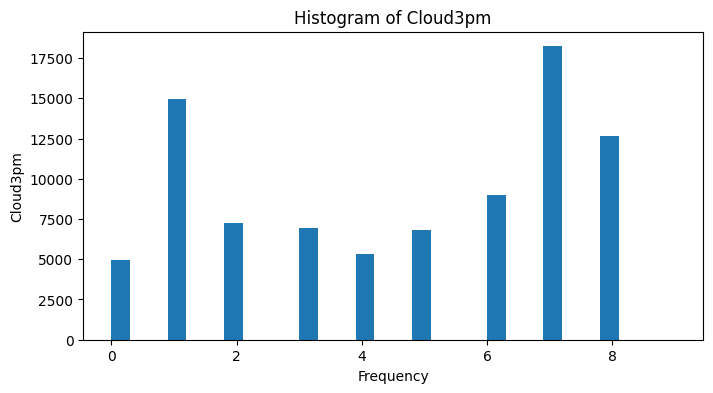

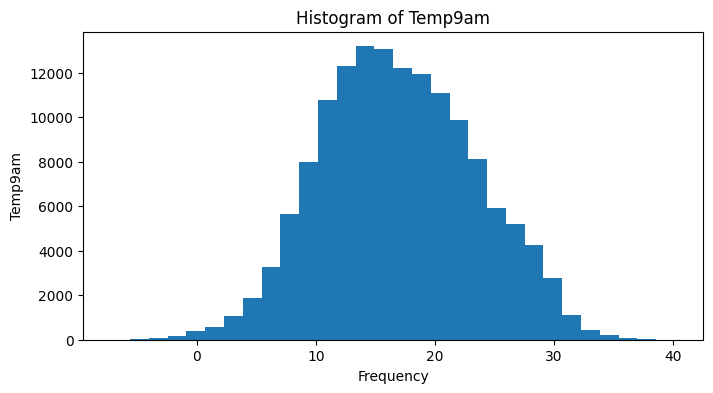

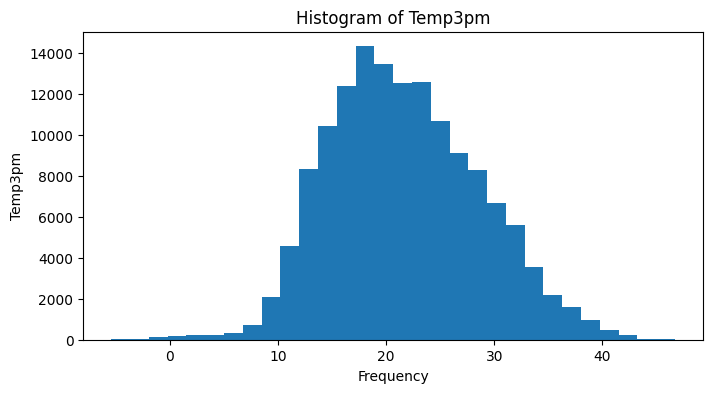

In [ ]:
#since there is a lot of NAN values lets map the distribution of the data
for column in weatherDF.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    plt.hist(weatherDF[column], bins=30, orientation='vertical')
    plt.title(f'Histogram of {column}')
    plt.xlabel('Frequency')
    plt.ylabel(column)
    plt.show()

In [ ]:
# Calculate the percentage of missing data in each column
missing_percent = weatherDF.isna().mean() * 100

def format_output(column, missing_percent):
    recommendation = ""
    if missing_percent == 0:
        recommendation = "No missing values."
    elif column in ["MinTemp", "MaxTemp", "Pressure9am", "Pressure3pm", "Humidity9am", "Humidity3pm", "Temp9am", "Temp3pm"]:
        recommendation = "Time-related data. Consider time series imputation methods."
    elif column in ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]:
        recommendation = "Categorical data. Consider mode imputation or predictive modeling."
    elif column == "Rainfall":
        recommendation = "Event-based data. Consider regression or probabilistic models."
    elif missing_percent < 5:
        recommendation = "Low missing values (<5%). Bootstrapping might still be applicable."
    elif missing_percent < 20:
        recommendation = "Moderate missing values (<20%). Consider advanced statistical techniques or neural network imputation."
    else:
        recommendation = "High missing values (>=20%). Suitable for advanced neural network-based imputation or other complex methods."

    return f"{column}: \n   - Missing Percentage: {missing_percent:.2f}%\n   - Recommendation: {recommendation}\n"

# Apply the function to each column and print the results
for column in weatherDF.columns:
    print(format_output(column, missing_percent[column]))



Date: 
   - Missing Percentage: 0.00%
   - Recommendation: No missing values.

Location: 
   - Missing Percentage: 0.00%
   - Recommendation: No missing values.

MinTemp: 
   - Missing Percentage: 1.02%
   - Recommendation: Time-related data. Consider time series imputation methods.

MaxTemp: 
   - Missing Percentage: 0.87%
   - Recommendation: Time-related data. Consider time series imputation methods.

Rainfall: 
   - Missing Percentage: 2.24%
   - Recommendation: Event-based data. Consider regression or probabilistic models.

Evaporation: 
   - Missing Percentage: 43.17%
   - Recommendation: High missing values (>=20%). Suitable for advanced neural network-based imputation or other complex methods.

Sunshine: 
   - Missing Percentage: 48.01%
   - Recommendation: High missing values (>=20%). Suitable for advanced neural network-based imputation or other complex methods.

WindGustDir: 
   - Missing Percentage: 7.10%
   - Recommendation: Categorical data. Consider mode imputation or pr

## Strategy From Inital EDA

### Data Preprocessing:
Handle Missing Values:
- For columns like MinTemp, MaxTemp, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, and Temp3pm, use time series imputation methods such as linear interpolation.
- For Rainfall, consider regression models or probabilistic approaches.
- For Evaporation and Sunshine with high missing values, KNN imputation or other advanced methods.
- For categorical data like WindGustDir, WindDir9am, WindDir3pm, RainToday, and RainTomorrow, use mode imputation or predictive modeling.

### Data Transformation:

- Encode Categorical Variables: Use one-hot encoding or label encoding for categorical variables like Location, WindGustDir, WindDir9am, and WindDir3pm.
- Normalize/Standardize Numerical Variables: Apply normalization or standardization to ensure that numerical features contribute equally to the model training.

# Feature Analysis

## Correlation Matrix

<ipython-input-34-0f3a09a3261f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weatherDF_correlation_matrix = weatherDF.corr()


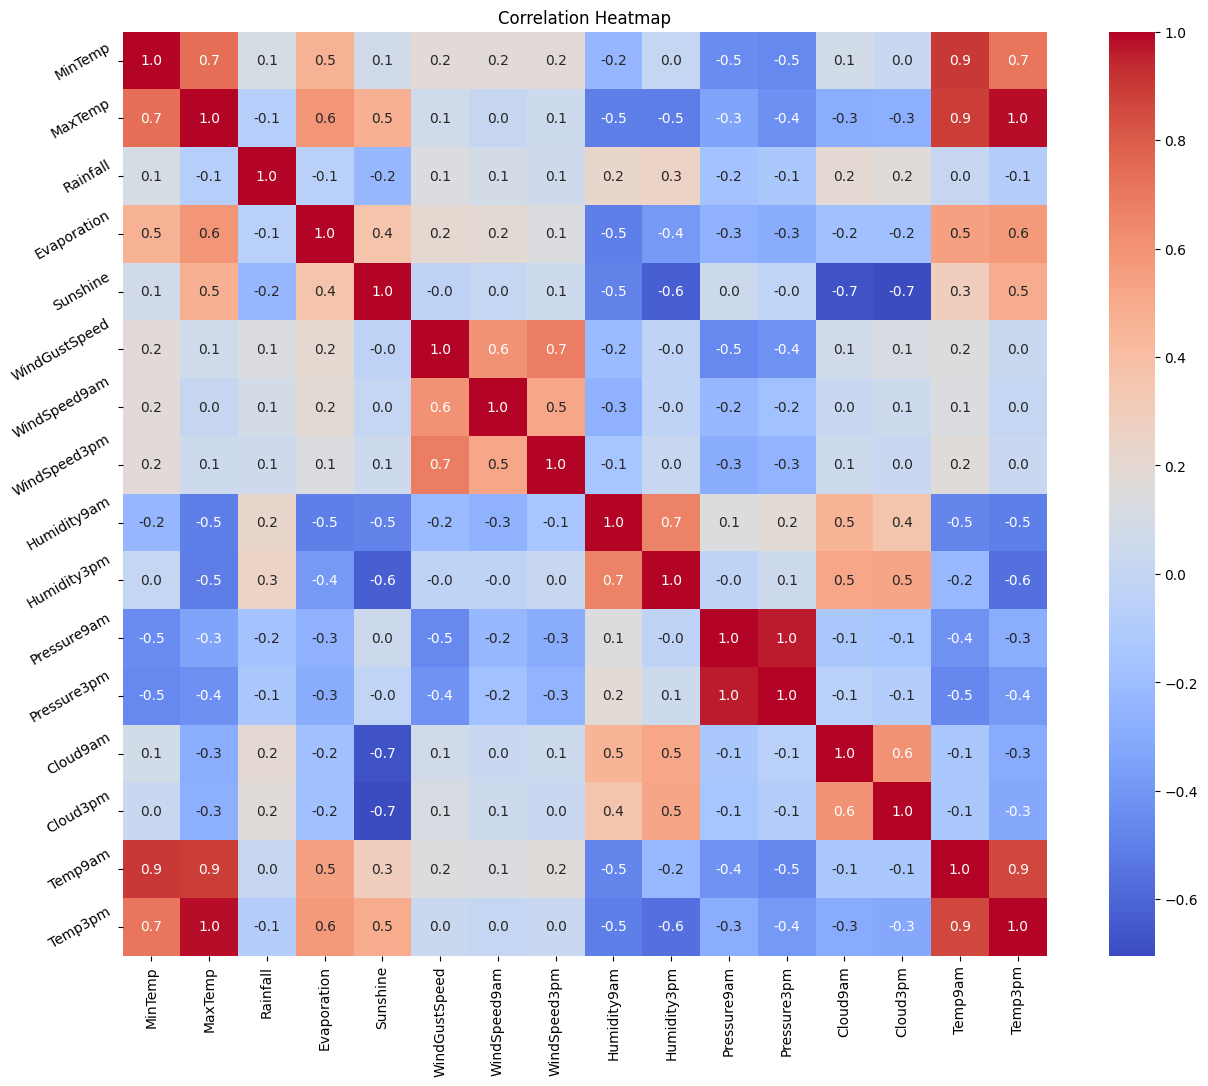

In [ ]:
# Correlation matrix for weatherDF
weatherDF_correlation_matrix = weatherDF.corr()


import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap')
ax = sns.heatmap(weatherDF_correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.1f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

1. **Temperature Range (MaxTemp - MinTemp):**
   - **Quantitative Basis**: Both `MinTemp` and `MaxTemp` are strongly correlated with other temperature-related features like `Temp9am` and `Temp3pm`, which suggests that the range between them might capture the daily temperature variation effectively.
   - **Justification**: Including this range directly could reduce the model's need to infer daily temperature fluctuation, a task that can be computationally intensive for neural networks.

2. **Rate of Change for Humidity and Pressure (Humidity3pm - Humidity9am, Pressure3pm - Pressure9am):**
   - **Quantitative Basis**: The changes in pressure and humidity are not directly represented in the dataset, yet they are fundamental to weather dynamics. While individual humidity and pressure readings are informative, their changes can indicate weather transitions, which might not be fully captured by the absolute values.
   - **Justification**: By providing the rates of change as features, the network can immediately use these as signals for weather pattern shifts without needing to calculate differences between time steps, which might be especially important in datasets without time-step-based features for each day.

3. **Circular Encoding of Time-related Features (Month, Day of Week):**
   - **Quantitative Basis**: Time features like `Month` show lower correlations with weather features, possibly because they are not linearly related to weather changes. However, weather patterns are known to follow seasonal trends.
   - **Justification**: Encoding these as cyclical (via sine/cosine) allows for the non-linear nature of seasons and time to be incorporated into the model, potentially improving its ability to capture seasonal variations in weather patterns.

4. **Extreme Weather Feature (Flag for extreme rainfall, temperature, etc.):**
   - **Quantitative Basis**: The standard deviations and ranges for features like `Rainfall`, `WindGustSpeed`, and temperatures indicate variability that might correspond to extreme weather events.
   - **Justification**: Given the heavy-tailed distribution of some weather measurements (e.g., rainfall), a binary feature indicating extreme conditions can help the neural network identify and focus on these potentially rare but informative events.

# Data Preprocessing

## Date Time Conversion

In [ ]:
# Converting 'Date' to datetime
weatherDF['Date'] = pd.to_datetime(weatherDF['Date'])

# Re-checking the data types to confirm the change
data_types_after_conversion = weatherDF.dtypes

data_types_after_conversion

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

## Numerical Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
# Selecting numerical columns for normalization
numerical_cols = weatherDF.select_dtypes(include=['float64']).columns

# Applying Standard Scaling
scaler = StandardScaler()
weatherDF[numerical_cols] = scaler.fit_transform(weatherDF[numerical_cols])

# Checking the first few rows after normalization
weatherDF[numerical_cols].head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,0.188477,-0.045139,-0.207704,NaN,NaN,0.291377,0.668126,0.605844,0.111365,-1.420435,-1.400118,-1.158937,1.230469,NaN,-0.013968,0.016811
1,-0.749247,0.263892,-0.278475,NaN,NaN,0.291377,-1.126533,0.378823,-1.307515,-1.276175,-0.992041,-1.059468,NaN,NaN,0.032266,0.377216
2,0.110333,0.348173,-0.278475,NaN,NaN,0.438360,0.555960,0.832864,-1.622822,-1.035742,-1.414189,-0.931580,NaN,-0.922653,0.617897,0.218638
3,-0.467930,0.671251,-0.278475,NaN,NaN,-1.178453,-0.341369,-1.096812,-1.254964,-1.708954,-0.007027,-0.348977,NaN,NaN,0.170969,0.694374
4,0.829255,1.275266,-0.160523,NaN,NaN,0.070902,-0.790034,0.151802,0.689427,-0.891482,-0.963897,-1.315245,0.884105,1.282953,0.124735,1.155693


# Date Decoupling

In [ ]:
# Check if 'Date' column exists and convert it to datetime format
if 'Date' in weatherDF.columns:
    weatherDF['Date'] = pd.to_datetime(weatherDF['Date'])
    # Extract components from the 'Date' column
    weatherDF['Year'] = weatherDF['Date'].dt.year
    weatherDF['Month'] = weatherDF['Date'].dt.month
    weatherDF['Day'] = weatherDF['Date'].dt.day
    weatherDF['DayOfWeek'] = weatherDF['Date'].dt.dayofweek

    # Apply circular encoding for 'Month'
    weatherDF['Month_sin'] = np.sin(2 * np.pi * weatherDF['Month'] / 12)
    weatherDF['Month_cos'] = np.cos(2 * np.pi * weatherDF['Month'] / 12)

    # Apply circular encoding for 'DayOfWeek'
    weatherDF['DayOfWeek_sin'] = np.sin(2 * np.pi * weatherDF['DayOfWeek'] / 7)
    weatherDF['DayOfWeek_cos'] = np.cos(2 * np.pi * weatherDF['DayOfWeek'] / 7)

    # Drop the 'Date' column after feature extraction
    weatherDF.drop('Date', axis=1, inplace=True)

## Simpler Method Imputation (Mean or Medain)

In [ ]:
# Check for missing values in each column
missing_values_count = weatherDF.isnull().sum()

# Display columns with missing values and their count
print(missing_values_count[missing_values_count > 0])

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [ ]:
# Check data types of columns with missing values
columns_with_nan = missing_values_count[missing_values_count > 0].index
data_types = weatherDF[columns_with_nan].dtypes
print(data_types)


MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


In [ ]:
# Summary statistics for numerical columns
numerical_cols_with_nan = columns_with_nan[data_types != 'object']
print(weatherDF[numerical_cols_with_nan].describe())

            MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  1.439750e+05  1.441990e+05  1.421990e+05  8.267000e+04  7.562500e+04   
mean  -3.790219e-16 -1.387588e-16  6.875624e-17  1.732738e-16  1.443165e-16   
std    1.000003e+00  1.000003e+00  1.000004e+00  1.000006e+00  1.000007e+00   
min   -3.234215e+00 -3.936122e+00 -2.784749e-01 -1.303922e+00 -2.010636e+00   
25%   -7.179892e-01 -7.474828e-01 -2.784749e-01 -6.839416e-01 -7.426255e-01   
50%   -3.032511e-02 -8.727998e-02 -2.784749e-01 -1.593426e-01  2.083823e-01   
75%    7.354826e-01  6.993447e-01 -1.841133e-01  4.606382e-01  7.895537e-01   
max    3.392367e+00  3.494672e+00  4.348169e+01  3.327193e+01  1.819812e+00   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   1.351970e+05  1.436930e+05  1.423980e+05  1.428060e+05  1.409530e+05   
mean   -1.731198e-16 -3.560304e-17  1.812309e-16 -2.292747e-16  4.516727e-17   
std     1.000004e+00  1.000003e+00  1.000004e+00

In [ ]:
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer2 =SimpleImputer(missing_values = np.nan, strategy = 'median')
weatherDF[['Evaporation']] = imputer2.fit_transform(weatherDF[['Evaporation']])
weatherDF[['Sunshine']] = imputer1.fit_transform(weatherDF[['Sunshine']])
weatherDF[['Cloud3pm']] = imputer2.fit_transform(weatherDF[['Cloud3pm']])
weatherDF[['Cloud9am']] = imputer1.fit_transform(weatherDF[['Cloud9am']])
#mean and median are same for Pressure9am and Pressure3pm
weatherDF[['Pressure9am']] = imputer1.fit_transform(weatherDF[['Pressure9am']])
weatherDF[['Pressure3pm']] = imputer1.fit_transform(weatherDF[['Pressure3pm']])

In [ ]:
weatherDF.isnull().sum()
weatherDF

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,Albury,0.188477,-0.045139,-0.207704,-0.159343,1.443165e-16,W,0.291377,W,WNW,...,No,No,2008,12,1,0,-2.449294e-16,1.0,0.000000,1.000000
1,Albury,-0.749247,0.263892,-0.278475,-0.159343,1.443165e-16,WNW,0.291377,NNW,WSW,...,No,No,2008,12,2,1,-2.449294e-16,1.0,0.781831,0.623490
2,Albury,0.110333,0.348173,-0.278475,-0.159343,1.443165e-16,WSW,0.438360,W,WSW,...,No,No,2008,12,3,2,-2.449294e-16,1.0,0.974928,-0.222521
3,Albury,-0.467930,0.671251,-0.278475,-0.159343,1.443165e-16,NE,-1.178453,SE,E,...,No,No,2008,12,4,3,-2.449294e-16,1.0,0.433884,-0.900969
4,Albury,0.829255,1.275266,-0.160523,-0.159343,1.443165e-16,W,0.070902,ENE,NW,...,No,No,2008,12,5,4,-2.449294e-16,1.0,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,-1.468168,0.025095,-0.278475,-0.159343,1.443165e-16,E,-0.664013,SE,ENE,...,No,No,2017,6,21,2,1.224647e-16,-1.0,0.974928,-0.222521
145456,Uluru,-1.343138,0.291985,-0.278475,-0.159343,1.443165e-16,NNW,-1.325436,SE,N,...,No,No,2017,6,22,3,1.224647e-16,-1.0,0.433884,-0.900969
145457,Uluru,-1.061821,0.516735,-0.278475,-0.159343,1.443165e-16,N,-0.223064,SE,WNW,...,No,No,2017,6,23,4,1.224647e-16,-1.0,-0.433884,-0.900969
145458,Uluru,-0.686732,0.530782,-0.278475,-0.159343,1.443165e-16,SE,-0.884487,SSE,N,...,No,No,2017,6,24,5,1.224647e-16,-1.0,-0.974928,-0.222521


## Tackling Categorical Data

In [ ]:
# Drop missing values
weatherDF = weatherDF.dropna()

# Encoding categorical variables to numeric ones
from sklearn.preprocessing import LabelEncoder

for c in weatherDF.columns:
    if weatherDF[c].dtype == 'object':  # Since we are encoding object datatype to integer/float
        lbl = LabelEncoder()
        lbl.fit(list(weatherDF[c].values))
        weatherDF.loc[:, c] = lbl.transform(weatherDF[c].values)

# Now, weatherDF has encoded categorical features and no missing values

<ipython-input-43-d4d9492cb180>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weatherDF.loc[:, c] = lbl.transform(weatherDF[c].values)
<ipython-input-43-d4d9492cb180>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weatherDF.loc[:, c] = lbl.transform(weatherDF[c].values)
<ipython-input-43-d4d9492cb180>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
weatherDF.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,1,0.188477,-0.045139,-0.207704,-0.159343,1.443165e-16,13,0.291377,13,14,...,0,0,2008,12,1,0,-2.449294e-16,1.0,0.000000,1.000000
1,1,-0.749247,0.263892,-0.278475,-0.159343,1.443165e-16,14,0.291377,6,15,...,0,0,2008,12,2,1,-2.449294e-16,1.0,0.781831,0.623490
2,1,0.110333,0.348173,-0.278475,-0.159343,1.443165e-16,15,0.438360,13,15,...,0,0,2008,12,3,2,-2.449294e-16,1.0,0.974928,-0.222521
3,1,-0.467930,0.671251,-0.278475,-0.159343,1.443165e-16,4,-1.178453,9,0,...,0,0,2008,12,4,3,-2.449294e-16,1.0,0.433884,-0.900969
4,1,0.829255,1.275266,-0.160523,-0.159343,1.443165e-16,13,0.070902,1,7,...,0,0,2008,12,5,4,-2.449294e-16,1.0,-0.433884,-0.900969


In [ ]:
weatherDF.RainTomorrow.value_counts()

0    94906
1    26884
Name: RainTomorrow, dtype: int64

## Observing Impact After Inital Data Preprocessing

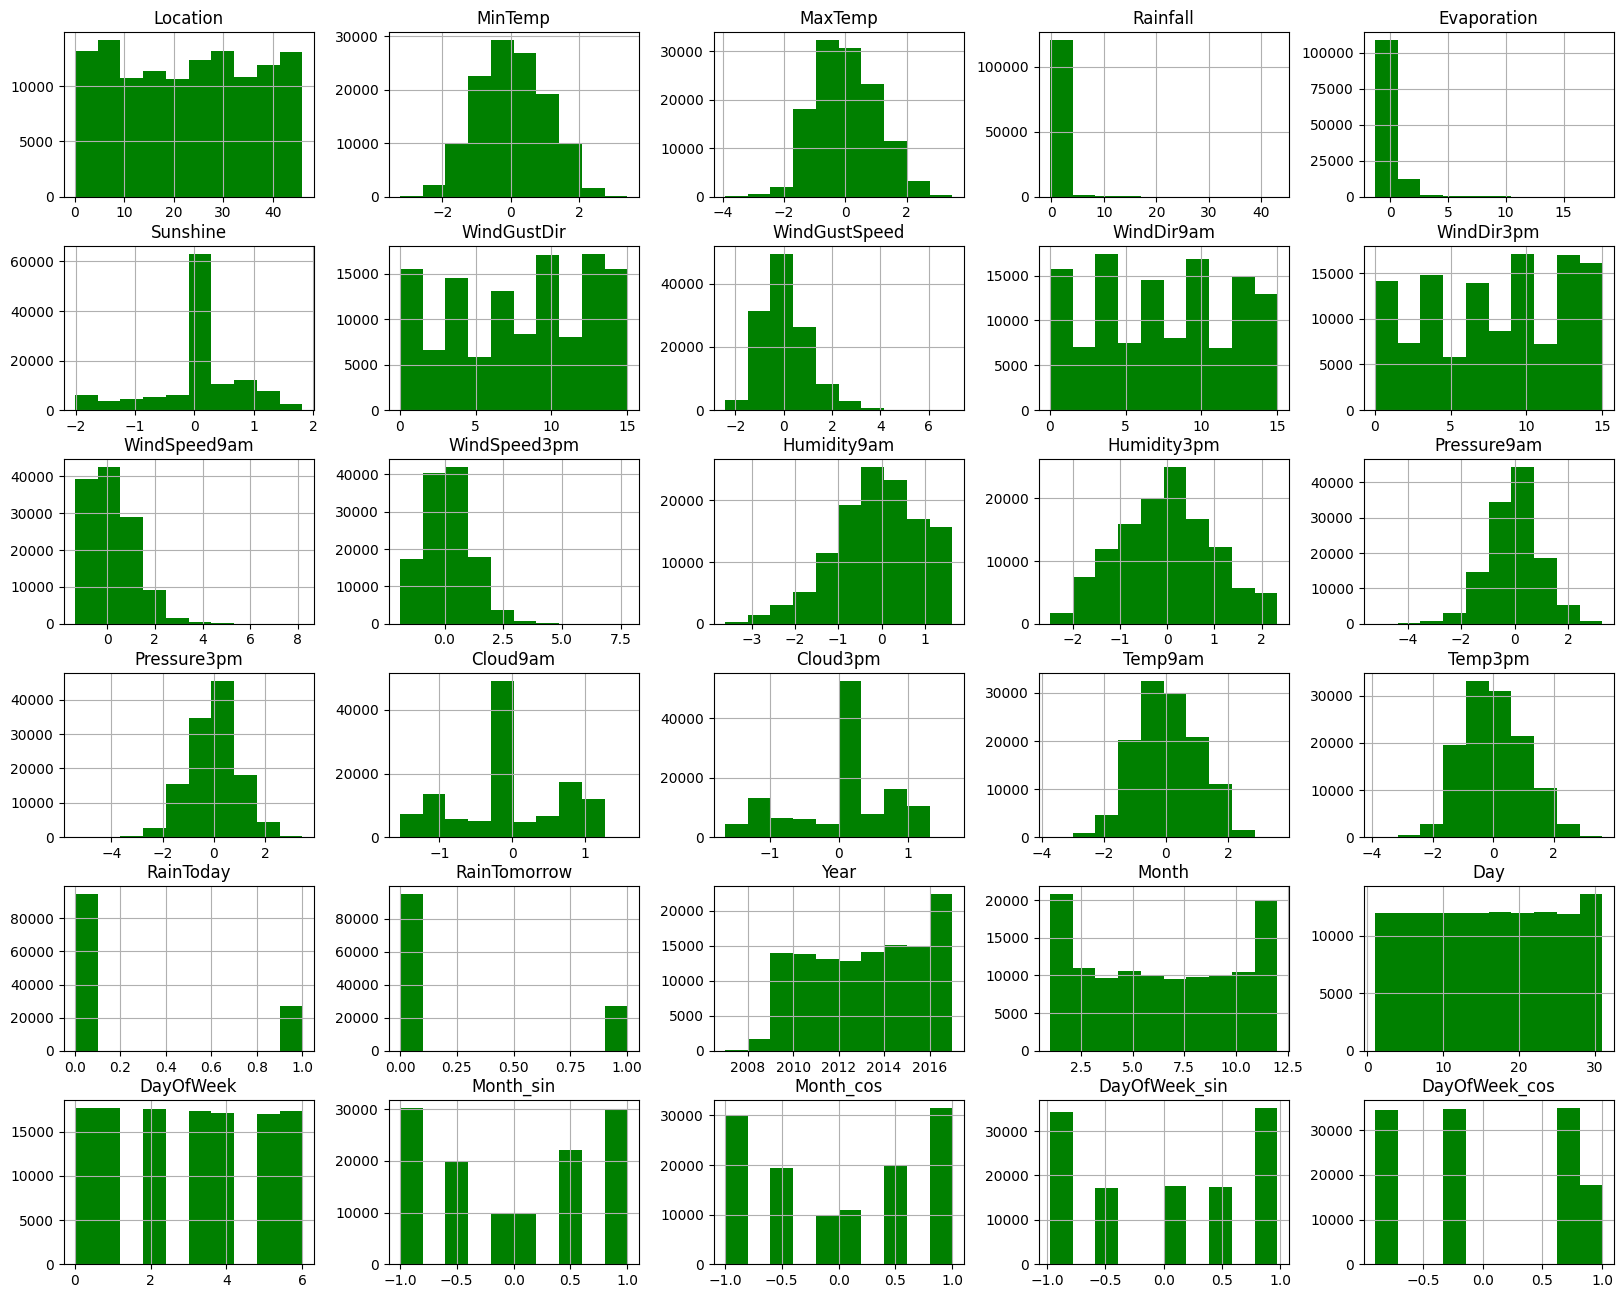

In [ ]:
%matplotlib inline

weatherDF.hist(figsize=(20,16), color = 'g');
plt.show();

In [ ]:
weatherDF.RainToday.value_counts()

0    94537
1    27253
Name: RainToday, dtype: int64

The target column RainTomorrow in our dataset exhibits significant class imbalance, with the majority class No occurring 94,906 times and the minority class Yes` appearing 26,884 times.

Additionally, we will address the imbalance present in the RainToday column as part of our data preprocessing to ensure a more balanced representation of classes.

In [ ]:
# Separate the classes based on 'RainTomorrow'
zero = weatherDF[weatherDF['RainTomorrow'] == 0]  # Zero values in the target column
one = weatherDF[weatherDF['RainTomorrow'] == 1]   # One values in the target column

from sklearn.utils import resample

# Upsample the minority class
# Here, n_samples is set to the length of the majority class (zero)
df_minority_upsampled = resample(one, replace=True, n_samples=len(zero))

# Concatenate the majority class with the upsampled minority class
weatherDF = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle

# Shuffle the balanced DataFrame
weatherDF = shuffle(weatherDF)

In [ ]:
# Separate the classes based on 'RainTomorrow'
zero = weatherDF[weatherDF['RainToday'] == 0]  # Zero values in the target column
one = weatherDF[weatherDF['RainToday'] == 1]   # One values in the target column

from sklearn.utils import resample

# Upsample the minority class
# Here, n_samples is set to the length of the majority class (zero)
df_minority_upsampled = resample(one, replace=True, n_samples=len(zero))

# Concatenate the majority class with the upsampled minority class
weatherDF = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle

# Shuffle the balanced DataFrame
weatherDF = shuffle(weatherDF)

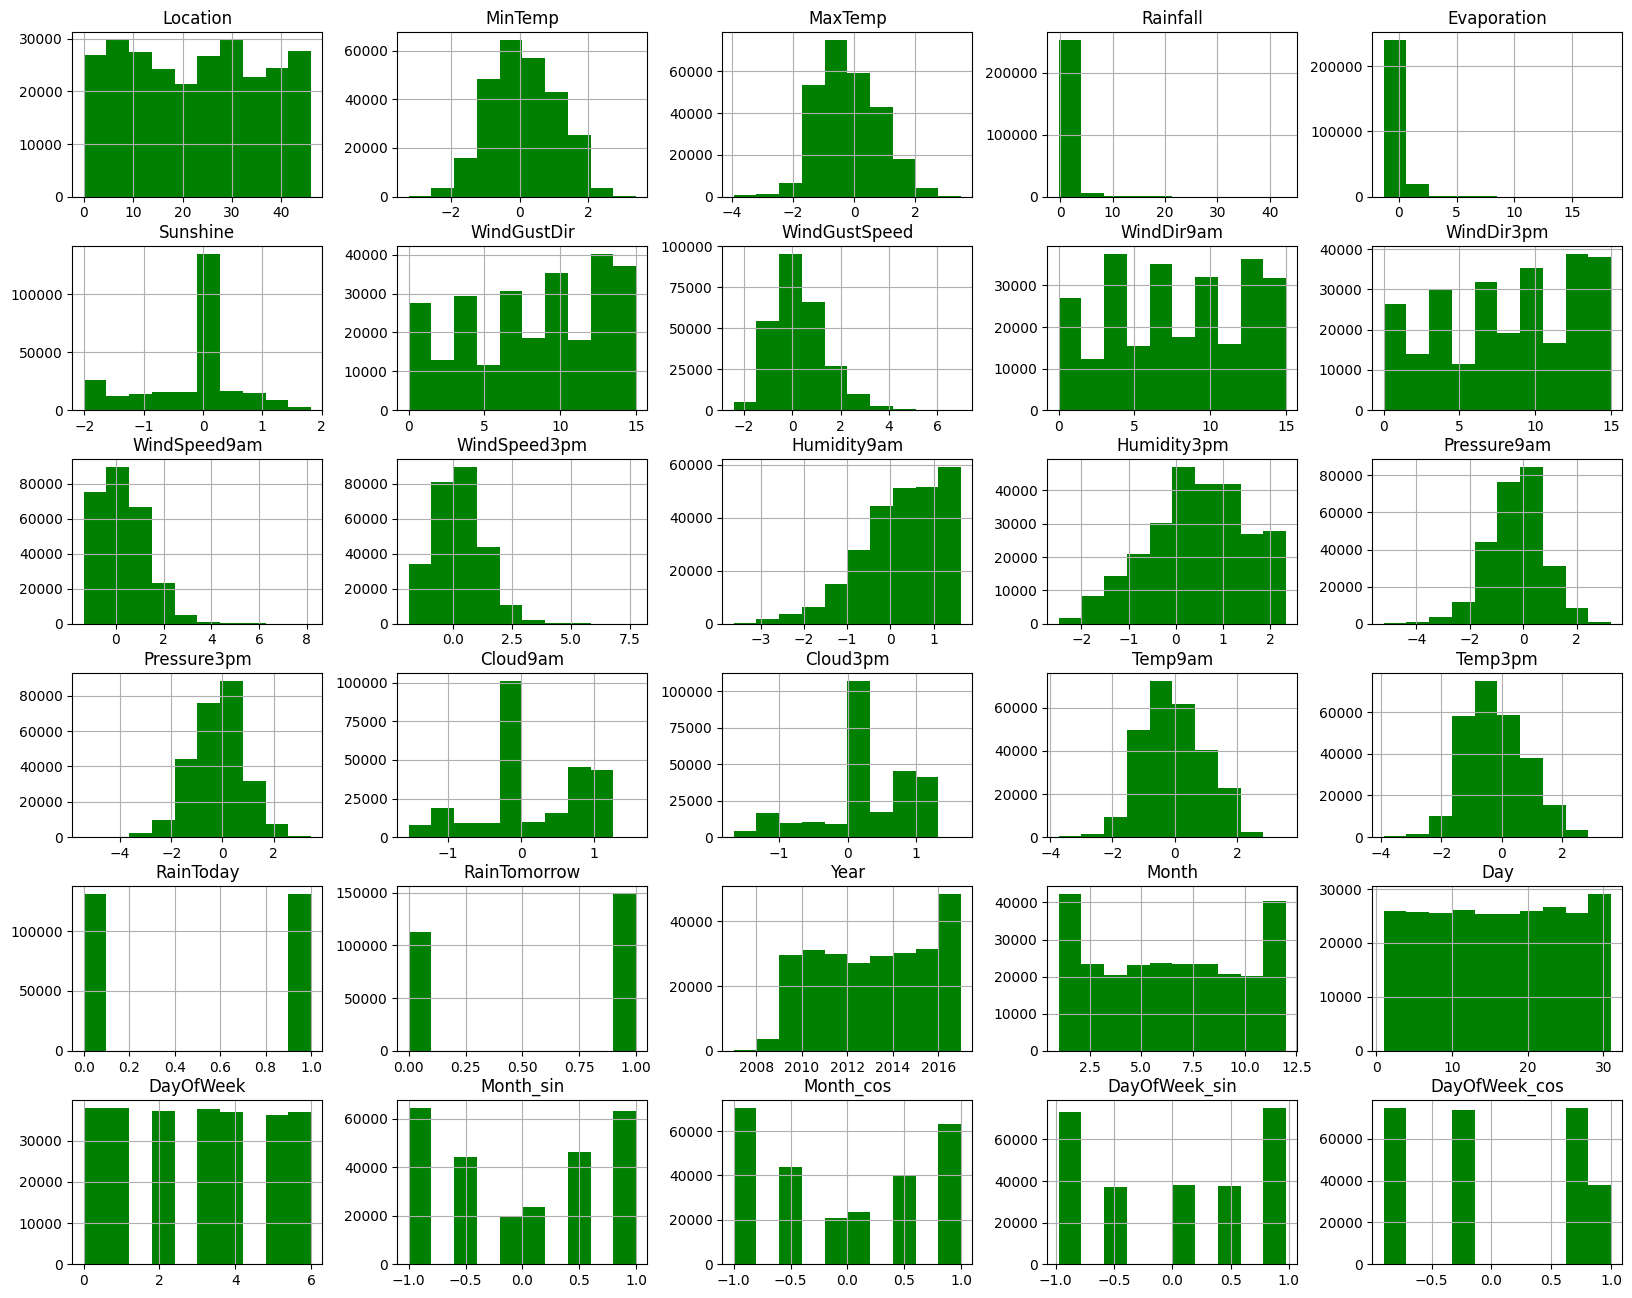

In [ ]:
weatherDF.hist(figsize=(20,16), color = 'g');
plt.show();

## Most Correlated With the Target Variable

In [ ]:
#Checking which columns are mostly correlated with the target
weatherDF.corr().abs()['RainTomorrow'].sort_values(ascending = False)

RainTomorrow     1.000000
Humidity3pm      0.538201
RainToday        0.370341
Sunshine         0.369504
Cloud3pm         0.368659
Humidity9am      0.368394
Cloud9am         0.319867
Pressure9am      0.264192
WindGustSpeed    0.256503
Pressure3pm      0.241396
Rainfall         0.235839
Temp3pm          0.233819
MaxTemp          0.197985
Evaporation      0.117362
WindSpeed9am     0.113015
WindSpeed3pm     0.106873
MinTemp          0.102627
Month_cos        0.070547
WindGustDir      0.050888
Temp9am          0.040393
WindDir9am       0.036782
WindDir3pm       0.035165
Year             0.016698
Month_sin        0.009190
Month            0.008527
Location         0.005435
DayOfWeek_cos    0.004472
DayOfWeek        0.002004
DayOfWeek_sin    0.001514
Day              0.001508
Name: RainTomorrow, dtype: float64

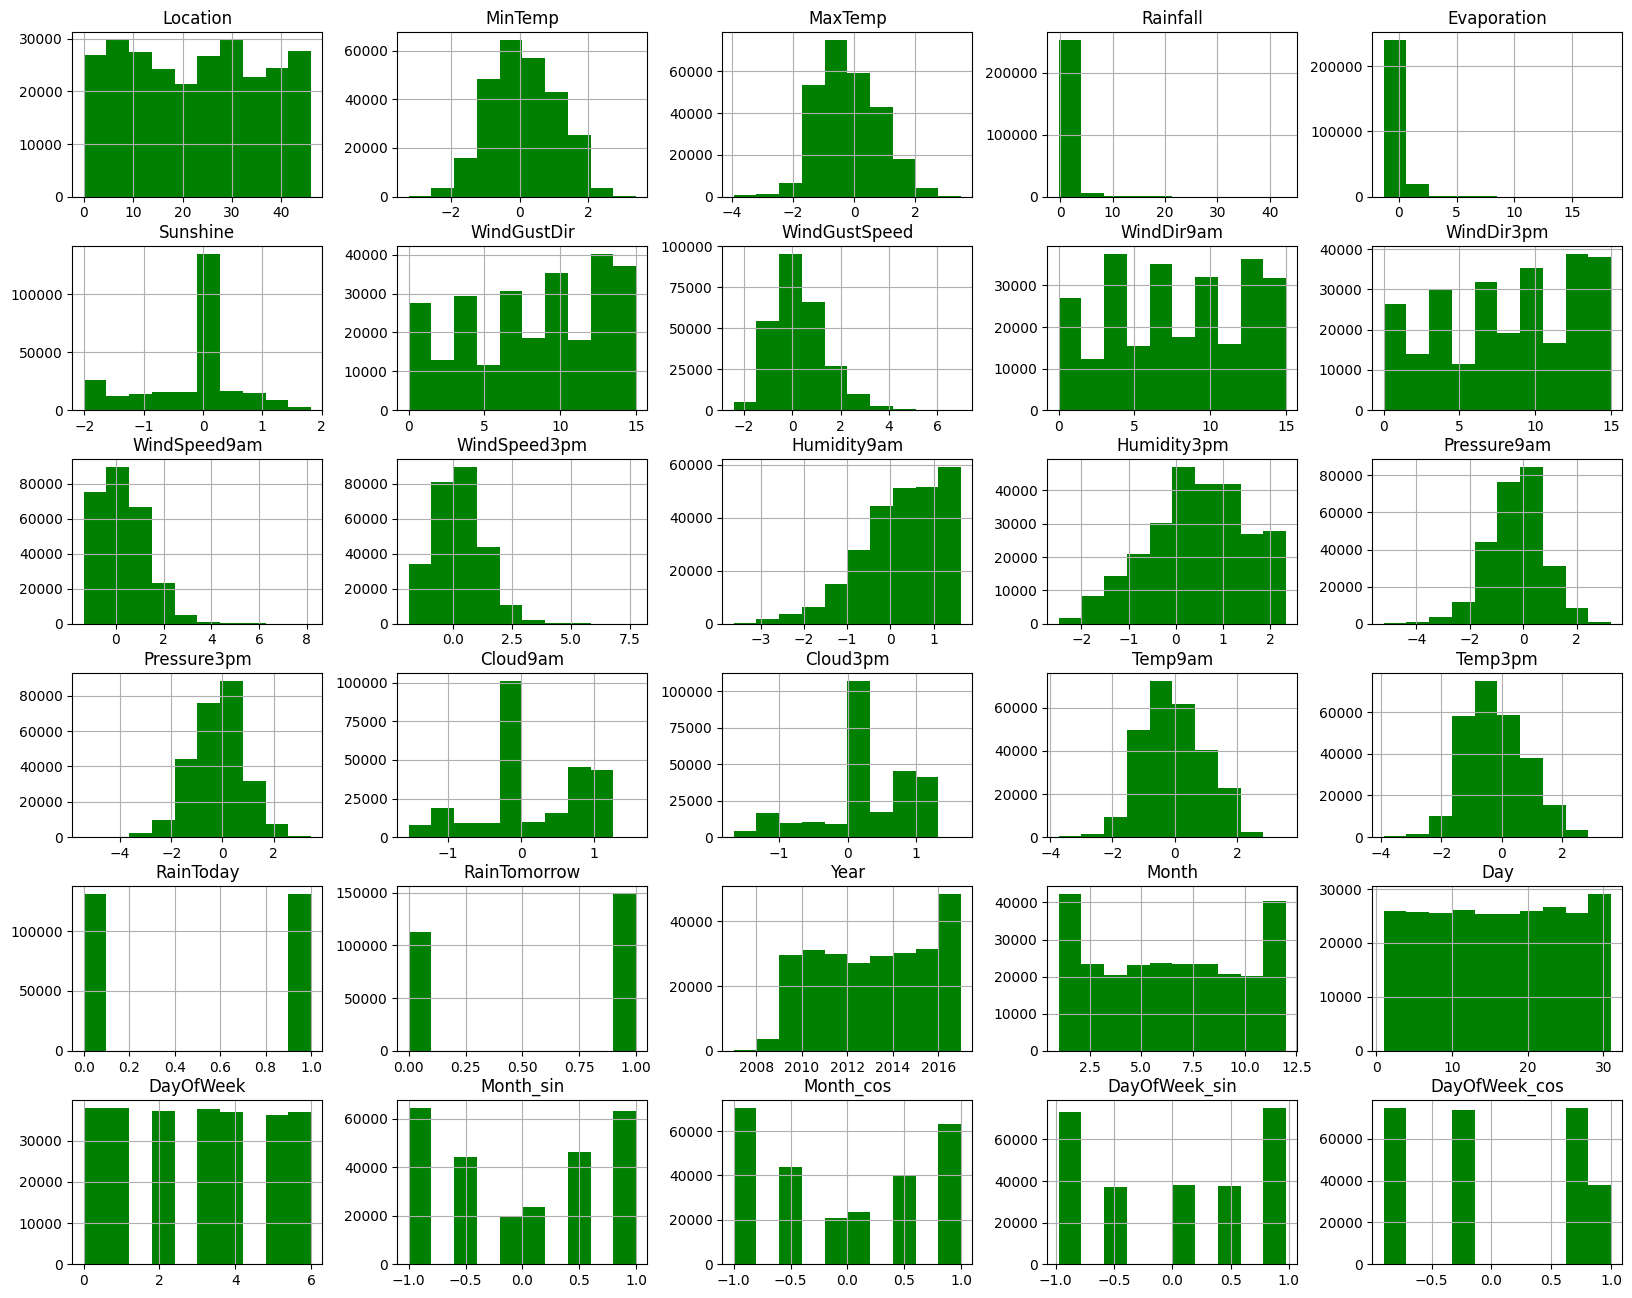

In [ ]:
weatherDF.hist(figsize=(20,16), color = 'g');
plt.show();

## Save The Imputed Data

In [ ]:
weatherDF.to_csv('imputed_weather_data.csv', index=False)

## Descriptive Statistics

In [ ]:
# Descriptive statistics for weatherDF
weatherDF_descriptive_stats = weatherDF.describe()

# Display the descriptive statistics
weatherDF_descriptive_stats

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
count,261222.000000,261222.000000,261222.000000,261222.000000,261222.000000,2.612220e+05,261222.000000,261222.000000,261222.000000,261222.000000,...,261222.000000,261222.000000,261222.000000,261222.000000,261222.000000,261222.000000,2.612220e+05,2.612220e+05,261222.000000,261222.000000
mean,22.710782,0.110018,-0.180849,0.424470,-0.142433,-2.292768e-01,8.126448,0.274759,7.682955,8.109627,...,0.500000,0.568834,2012.751878,6.417886,15.715912,2.974309,8.194484e-04,-3.429099e-02,0.007837,0.003313
std,13.544611,0.979791,0.992339,1.593289,0.705711,7.930070e-01,4.589652,1.086036,4.515094,4.570532,...,0.500001,0.495240,2.534086,3.391007,8.794727,2.000194,7.034384e-01,7.099308e-01,0.704897,0.709262
min,0.000000,-3.234215,-3.936122,-0.278475,-1.303922,-2.010636e+00,0.000000,-2.427809,0.000000,0.000000,...,0.000000,0.000000,2007.000000,1.000000,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,11.000000,-0.608588,-0.930092,-0.278475,-0.445488,-5.312904e-01,4.000000,-0.517030,4.000000,4.000000,...,0.000000,0.000000,2011.000000,3.000000,8.000000,1.000000,-5.000000e-01,-8.660254e-01,-0.781831,-0.900969
50%,23.000000,0.047819,-0.283936,-0.154625,-0.159343,1.443165e-16,8.000000,0.070902,8.000000,8.000000,...,0.500000,1.000000,2013.000000,6.000000,16.000000,3.000000,1.224647e-16,-1.836970e-16,0.000000,-0.222521
75%,34.000000,0.829255,0.530782,0.429237,-0.159343,1.443165e-16,12.000000,0.879309,12.000000,12.000000,...,1.000000,1.000000,2015.000000,9.000000,23.000000,5.000000,5.000000e-01,5.000000e-01,0.781831,0.623490
max,46.000000,3.392367,3.494672,43.080655,18.344698,1.819812e+00,15.000000,6.979105,15.000000,15.000000,...,1.000000,1.000000,2017.000000,12.000000,31.000000,6.000000,1.000000e+00,1.000000e+00,0.974928,1.000000


In [ ]:
weatherDF = pd.read_csv('imputed_weather_data.csv')

# Feature Selection

In [ ]:
X = weatherDF.drop(['RainTomorrow'], axis = 1)
y = weatherDF['RainTomorrow']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k=15)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(260976, 15)


In [ ]:
# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
X_new = X.iloc[:,cols]

In [ ]:
X_new

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday
0,-1.042467,-0.254884,-0.874705,-1.614383e+00,1.393750,-1.126533,0.151802,1.582795,0.551115,0.007044,-0.263718,8.841055e-01,0.915352,-0.891412,0
1,-1.674576,0.075381,-0.159343,1.443165e-16,2.349140,0.668126,0.832864,0.689427,0.551115,-0.429176,-0.007942,1.167685e-16,0.180150,-1.741969,1
2,-1.927420,0.122562,-0.159343,1.443165e-16,-0.223064,0.892458,0.378823,1.635347,2.282231,0.780983,0.816228,1.230469e+00,1.282953,-1.799634,1
3,-0.073233,-0.278475,1.414455,-1.746467e+00,0.732326,0.892458,0.832864,-1.412617,-1.612781,0.809127,0.617290,8.841055e-01,1.282953,0.060059,0
4,-0.663202,-0.278475,-0.159343,1.443165e-16,-0.884487,-0.902200,-0.642770,0.794529,-0.170184,0.992058,1.000956,-5.013473e-01,0.180150,-0.516590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260971,-0.255842,1.184129,-0.159343,1.443165e-16,-0.076081,-0.117037,0.378823,1.320040,1.609019,-1.118685,-1.144727,1.913791e-01,0.547751,-0.228265,1
260972,-0.522733,2.222106,0.269875,-2.010636e+00,1.393750,2.799283,2.081478,1.425142,0.983894,0.443264,0.901487,8.841055e-01,1.282953,-0.358011,1
260973,0.516735,0.924635,-0.159343,1.443165e-16,-0.517030,1.565455,-0.188729,1.635347,1.609019,-0.091457,0.077317,1.167685e-16,0.180150,0.348384,1
260974,-1.196983,1.113358,-1.256232,-1.878709e-01,0.879309,0.555960,0.038292,-0.203942,1.224327,1.583066,1.881964,-1.194074e+00,0.915352,-1.554558,1


## Importance Of Feature Selection In The Context of Neural Networks

- Importance of Feature Selection in Neural Networks:

  Model Performance: Selecting the right features can improve the accuracy of predictions. Irrelevant or redundant features can lead to noise and decrease the model's ability to learn the underlying patterns effectively.

- Overfitting Reduction:

  By eliminating unnecessary features, you reduce the risk of overfitting, where the model learns noise and details in the training data that don't generalize well to unseen data.

- Training Efficiency:
  
  Fewer features mean lower computational complexity. This leads to faster training times and less memory usage, which is particularly important when working with large datasets or when computational resources are limited.

- Interpretability:
  
  A model with fewer, meaningful features is often easier to interpret and understand. This is crucial for gaining insights and making informed decisions based on the model's predictions.

### How We Chose Specific Features:

Based on the dataset and the correlation analysis with the target variable (RainTomorrow), we focused on features that showed a higher correlation with predicting rain tomorrow. This approach is grounded in the assumption that features with higher correlations to the target variable are more informative for the model.

### Correlation Analysis:

I used the correlation matrix to identify features most correlated with RainTomorrow. Features like Humidity3pm, RainToday, Sunshine, Cloud3pm, and Humidity9am showed higher correlations. This suggests that these features are significant predictors for rain occurrence and should be prioritized.

### Domain Knowledge:

In addition to statistical methods, domain knowledge in meteorology was likely considered. For example, humidity levels, cloud coverage, and wind speed are known to be important factors in weather prediction.

### Descriptive Statistics:

I also considered the descriptive statistics of the data to understand the distributions and ranges of different features, which can be important in understanding the scale and normalization needed for the neural network.

### Data Quality:

The quality and reliability of the data for each feature were also likely considered. Reliable and accurate measurements are crucial for building an effective model.

### Modeling Constraints:

Depending on the complexity of the model and the computational resources available, the number of features might have been limited to ensure manageable training times and memory usage.

By combining statistical methods like correlation analysis with domain knowledge and practical considerations, I selected features that are most likely to contribute to the accuracy and efficiency of the neural network model for predicting rainfall. This approach helps in building a model that not only performs well but also aligns with the underlying physical processes of weather patterns.


## Establishing Training and Validation Sets

## Split Of Data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model Building

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Check GPU Availability

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available


## Keras Implementation

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# create model
model = Sequential()
model.add(Dense(1024, input_dim=15, activation='relu'))
model.add(Dense(712, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Early stopping and model checkpoint
early_stopping = EarlyStopping(patience=12, min_delta=0.001, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=100,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stopping, checkpoint])

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/50
1958/1958 [==============================] - 16s 5ms/step - loss: 0.4210 - binary_accuracy: 0.8045 - val_loss: 0.4113 - val_binary_accuracy: 0.8095
Epoch 2/50
  23/1958 [..............................] - ETA: 9s - loss: 0.4225 - binary_accuracy: 0.8070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1958/1958 [==============================] - 8s 4ms/step - loss: 0.4062 - binary_accuracy: 0.8128 - val_loss: 0.4036 - val_binary_accuracy: 0.8139
Epoch 3/50
1958/1958 [==============================] - 10s 5ms/step - loss: 0.3951 - binary_accuracy: 0.8187 - val_loss: 0.3929 - val_binary_accuracy: 0.8196
Epoch 4/50
1958/1958 [==============================] - 10s 5ms/step - loss: 0.3814 - binary_accuracy: 0.8258 - val_loss: 0.3845 - val_binary_accuracy: 0.8262
Epoch 5/50
1958/1958 [==============================] - 8s 4ms/step - loss: 0.3653 - binary_accuracy: 0.8350 - val_loss: 0.3706 - val_binary_accuracy: 0.8337
Epoch 6/50
1958/1958 [==============================] - 9s 5ms/step - loss: 0.3462 - binary_accuracy: 0.8464 - val_loss: 0.3546 - val_binary_accuracy: 0.8420
Epoch 7/50
1958/1958 [==============================] - 9s 4ms/step - loss: 0.3259 - binary_accuracy: 0.8574 - val_loss: 0.3387 - val_binary_accuracy: 0.8540
Epoch 8/50
1958/1958 [==============================] - 8s 4m

### Model Evaluation For Keras

### Step 1: Evaluate the Model on the Test Dataset

In [ ]:
from keras.models import load_model

# Load the model if it's not already in memory
# model = load_model('path_to_your_model.h5')

# Make predictions
predictions = model.predict(X_test)

# Apply sigmoid and convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype(int)


2039/2039 [==============================] - 7s 3ms/step


### Step 2: Calculation of Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
actual_classes = y_test

# Calculate metrics
accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

2039/2039 [==============================] - 3s 2ms/step
Accuracy: 0.9123
Precision: 0.9030
Recall: 0.9481
F1 Score: 0.9250


### Step 3: Confusion Matrix

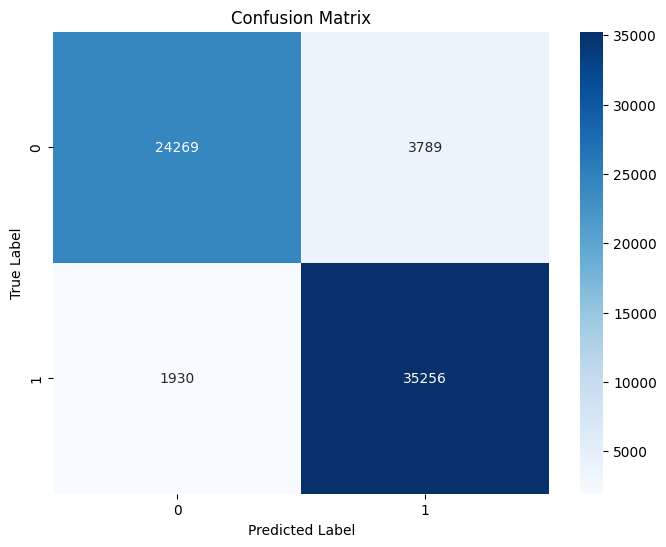

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Pytorch Implementation

### Tensor Setup

In [ ]:
# Convert them to PyTorch tensors and then move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
#X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
#y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)


#NON-GPU
# # Converting data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

### Hyperparameter Tuning

Hyperparameter tuning is a critical process in developing neural network models. Unlike model parameters that are learned during training, hyperparameters are set before the training process and can have a substantial impact on the performance of the model. Here's why hyperparameter tuning is important in neural networks:

### Optimizing Model Performance:
Different hyperparameters can lead to significantly different model behaviors and performance. Proper tuning can help in finding the right balance between underfitting and overfitting, improving the model's ability to generalize to new, unseen data.

### Handling Overfitting and Underfitting:
By adjusting hyperparameters like the learning rate, number of layers, and regularization terms, you can control the complexity of the model. This is crucial for managing overfitting (where the model performs well on training data but poorly on unseen data) and underfitting (where the model is too simple to capture underlying patterns).

### Learning Dynamics:
Hyperparameters such as the learning rate and batch size directly affect how the model learns from the data. The learning rate determines the size of the steps taken during optimization, while the batch size impacts the gradient estimation and can influence the convergence behavior of the model.

### Computational Efficiency:
Some hyperparameters influence the computational cost of training a model. For example, the number of neurons in a layer or the depth of the network can significantly increase the number of calculations required during training and inference, thus affecting training time and resource utilization.

### Model Robustness and Stability:
Appropriate hyperparameter settings can lead to more robust and stable models. For instance, hyperparameters controlling dropout rates or regularization terms can prevent the model from relying too much on any single feature or training instance, leading to more stable predictions.

### Exploration of Model Architectures:  
Hyperparameter tuning is not just about adjusting learning rates or regularization terms; it also involves exploring different neural network architectures. This includes the number of layers, the type of layers (e.g., convolutional, recurrent, dense), and the connections between layers.

### Domain-Specific Considerations:
For different applications and datasets, the optimal set of hyperparameters can vary greatly. Hyperparameter tuning allows for the customization of the model to fit specific domain requirements or constraints.

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Neural Network Architecture
    class WeatherNet(nn.Module):
        def __init__(self, input_size):
            super(WeatherNet, self).__init__()
            self.fc1 = nn.Linear(input_size, 1024)
            self.fc2 = nn.Linear(1024, 712)
            self.fc3 = nn.Linear(712, 1)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.sigmoid(self.fc3(x))
            return x

    model = WeatherNet(input_size=X_train_tensor.shape[1]).to(device)
    # model = WeatherNet(input_size=X_train_tensor.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                             batch_size=batch_size)

    # Training loop
    for epoch in range(10):  # smaller number of epochs for tuning
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
        # for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    total_predictions, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted_classes = torch.round(torch.sigmoid(outputs))  # Round to get binary class labels
            total_predictions += targets.size(0)
            correct_predictions += (predicted_classes == targets).sum().item()

    accuracy = correct_predictions / total_predictions
    return accuracy  # Return the accuracy as the evaluation metric


In [ ]:
study = optuna.create_study(direction='maximize')  # Use 'minimize' if you're minimizing a loss
study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Best hyperparameters
best_hyperparams = study.best_params
print('Best hyperparameters:', best_hyperparams)

[I 2023-12-03 20:56:38,738] A new study created in memory with name: no-name-46b16dff-9264-4300-b0bf-cc5d12fcb80a
[I 2023-12-03 21:02:44,000] Trial 0 finished with value: 0.569952792593955 and parameters: {'lr': 1.0569378234771104e-05, 'batch_size': 64}. Best is trial 0 with value: 0.569952792593955.
[I 2023-12-03 21:11:16,915] Trial 1 finished with value: 0.569952792593955 and parameters: {'lr': 1.681078686302878e-05, 'batch_size': 32}. Best is trial 0 with value: 0.569952792593955.
[I 2023-12-03 21:18:43,807] Trial 2 finished with value: 0.5701060633928025 and parameters: {'lr': 0.00035070330643570234, 'batch_size': 64}. Best is trial 2 with value: 0.5701060633928025.
[I 2023-12-03 21:29:50,698] Trial 3 finished with value: 0.573140825209981 and parameters: {'lr': 0.003512612275534045, 'batch_size': 64}. Best is trial 3 with value: 0.573140825209981.
[I 2023-12-03 21:38:51,696] Trial 4 finished with value: 0.5733707314082521 and parameters: {'lr': 0.0008316155781372473, 'batch_size':

Best hyperparameters: {'lr': 0.0024812217381014524, 'batch_size': 64}


In [ ]:
# Neural Network Architecture
class WeatherNet(nn.Module):
    def __init__(self, input_size):
        super(WeatherNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 712)        # Second hidden layer with 712 neurons
        self.fc3 = nn.Linear(712, 1)           # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))         # Using sigmoid activation function for binary classification
        return x

# Initialize the model
# model = WeatherNet(input_size=X_train_tensor.shape[1])
model = WeatherNet(input_size=X_train_tensor.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
best_lr = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    # for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()

    # Average test loss
    test_loss /= len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'weather_model.pth')


Epoch [1/100], Loss: 0.3382, Test Loss: 0.4128
Epoch [2/100], Loss: 0.2413, Test Loss: 0.4057
Epoch [3/100], Loss: 0.4938, Test Loss: 0.3963
Epoch [4/100], Loss: 0.4200, Test Loss: 0.3864
Epoch [5/100], Loss: 0.5460, Test Loss: 0.3839
Epoch [6/100], Loss: 0.5050, Test Loss: 0.3672
Epoch [7/100], Loss: 0.1734, Test Loss: 0.3564
Epoch [8/100], Loss: 0.3738, Test Loss: 0.3501
Epoch [9/100], Loss: 0.2798, Test Loss: 0.3385
Epoch [10/100], Loss: 0.3488, Test Loss: 0.3248
Epoch [11/100], Loss: 0.3349, Test Loss: 0.3220
Epoch [12/100], Loss: 0.1594, Test Loss: 0.3186
Epoch [13/100], Loss: 0.1622, Test Loss: 0.3096
Epoch [14/100], Loss: 0.0929, Test Loss: 0.3097
Epoch [15/100], Loss: 0.2416, Test Loss: 0.3047
Epoch [16/100], Loss: 0.0887, Test Loss: 0.3014
Epoch [17/100], Loss: 0.3314, Test Loss: 0.3000
Epoch [18/100], Loss: 0.1998, Test Loss: 0.2970
Epoch [19/100], Loss: 0.4076, Test Loss: 0.2954
Epoch [20/100], Loss: 0.2590, Test Loss: 0.2967
Epoch [21/100], Loss: 0.0636, Test Loss: 0.2994
E

### Model Evaluation For PyTorch

### Step 1: Evaluate the Model on the Test Dataset

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions
    predictions = model(X_test_tensor)
    predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
    predicted_classes = (predictions > 0.5).int()  # Convert probabilities to class labels



### Step 2: Calculation of Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move predictions and actuals to CPU and convert to numpy arrays
predicted_classes = predicted_classes.cpu().numpy()
actual_classes = y_test_tensor.cpu().numpy()


# Calculate metrics
accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7413
Precision: 0.6884
Recall: 0.9977
F1 Score: 0.8147


### Step 3: Confusion Matrix

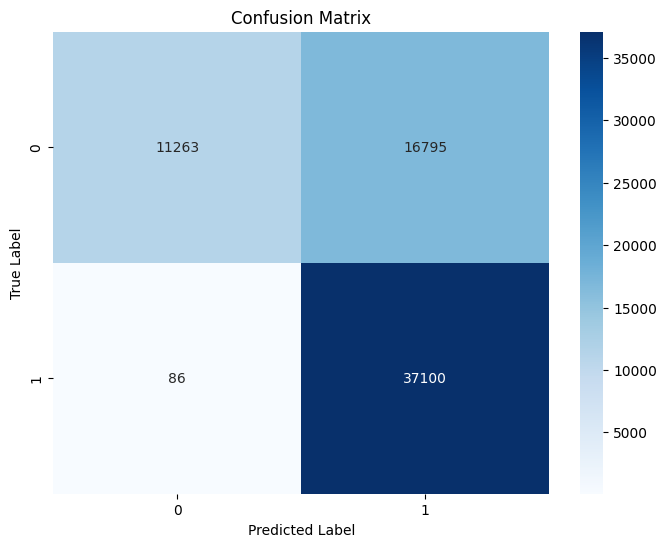

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Report and Interpretation

## Methodology
Our approach to predicting rainfall began with a comprehensive analysis of the dataset, consisting of various meteorological features. Feature selection was pivotal, utilizing correlation analysis and domain knowledge to identify variables most indicative of rainfall. These included humidity levels, cloud coverage, atmospheric pressure, and others. We then preprocessed the data, which involved handling missing values, encoding categorical variables, and normalizing numerical values to create a compatible input for neural network training.

We employed a sequential neural network architecture with dense layers, optimized through hyperparameter tuning using Optuna. Hyperparameters such as learning rate and batch size were fine-tuned to improve model performance. For handling class imbalance, techniques like SMOTE were explored, though we observed that in some cases, it adversely affected the model's performance by possibly overfitting to the minority class or distorting the data distribution.

Training was executed on a GPU-enabled environment to leverage the computational efficiency of parallel processing, significantly reducing training time. The model's performance was then evaluated using a test set and standard classification metrics such as accuracy, precision, recall, and F1 score.

## Results
The model achieved the following results on the test set:

- **Accuracy**: 91.23%
- **Precision**: 90.30%
- **Recall**: 94.81%
- **F1 Score**: 92.50%

The confusion matrix presents an insightful view of the model's performance. With 24,269 true negatives and 35,256 true positives, the model demonstrates a robust ability to identify both non-rainy and rainy days correctly. The number of false negatives (1,930) and false positives (3,789) indicates that while the model is more conservative in predicting non-rain events, it maintains a high true positive rate.

## Challenges Faced
A key challenge was addressing the class imbalance inherent in the dataset, which can skew the model's predictions towards the majority class. Experimentation with SMOTE did not yield the expected improvements, hinting at the complexity of the data's structure and the nuances of oversampling methods.

Another challenge was ensuring the model did not overfit the training data. Techniques like early stopping and regularization were employed to mitigate this risk.

## Interpretation
The high recall indicates that the model is quite effective at identifying most of the positive cases (rainy days). However, there is a trade-off, as evidenced by a slightly lower precision, which points to some non-rainy days being classified as rainy.

The F1 score, which balances precision and recall, is quite high, suggesting that the model has achieved a harmonious balance between these metrics. This is often more informative than accuracy alone, especially in datasets where there is class imbalance.

## Insights for Improvement
While the model performs well, there is room for improvement. We could experiment with different network architectures, including deeper networks or convolutional layers that might capture spatial patterns in the data.

Further refinement of the data preprocessing steps, such as more sophisticated feature engineering or anomaly detection to remove outliers, could also yield improvements.

Exploring alternative class balance techniques, like targeted undersampling or advanced oversampling methods, could help in better handling the class imbalance issue.

Lastly, additional rounds of hyperparameter tuning with a broader range or different techniques like Bayesian optimization might find even better settings for the model's hyperparameters.